### Imports

In [4]:
import numpy as np
import pandas as pd
import imblearn as imb
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from imblearn.pipeline import Pipeline

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Load Data

In [5]:
df = pd.read_csv("../data/review_2022_clean.csv")
df.head()

,text,label
0,bought fender telecaster salesperson told orig...,negative
1,visit son restaurant desert home food authenti...,positive
2,danielle great job listened cut hair way reque...,positive
3,saw lot roaches bathroom woke bed large dark s...,negative
4,ordered pork fried rice beef chow mei fun teri...,negative


In [6]:
df_sw = pd.read_csv("../data/review_2022_clean_sw.csv")
df_sw.head()

,text,label
0,i bought a fender telecaster that the salesper...,negative
1,this is our go to for take out when i visit my...,positive
2,danielle did a great job she listened and cut ...,positive
3,we saw a lot of roaches in the bathroom when w...,negative
4,we ordered pork fried rice and beef chow mei f...,negative


[Text(0, 0, '8566'), Text(0, 0, '2183'), Text(0, 0, '20916')]

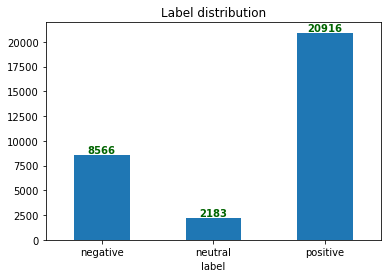

In [41]:
p = df.pivot_table(index='label', aggfunc='size').plot(kind='bar', title = 'Label distribution')
plt.xticks(rotation=0)
p.bar_label(p.containers[0], fontweight='bold',color='darkgreen')

In [52]:
print("Imbalanced data in dataset:")
total = df.shape[0]
value_counts = pd.DataFrame(df).label.value_counts()
positive_percent = value_counts["positive"]/total*100
negative_percent = value_counts["negative"]/total*100
neutral_percent = value_counts["neutral"]/total*100

print("Postive - {:04.2f}".format(positive_percent)+'%')
print("Negative - {:04.2f}".format(negative_percent)+'%')
print("Neutral - {:04.2f}".format(neutral_percent)+'%')


Imbalanced data in dataset:
Postive - 66.05%
Negative - 27.05%
Neutral - 6.89%


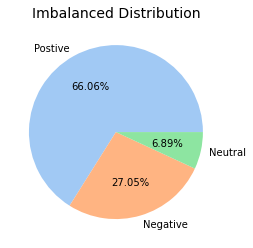

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

#define data
data = [66.05, 27.05, 6.89]
labels = ['Postive', 'Negative', 'Neutral']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.2f%%')
plt.title("Imbalanced Distribution", fontsize=14);
plt.show()

### Train-Test Split

Create a function to perform train-test split.

In [7]:
def split(stop_words=False):
  if stop_words:
    X = df_sw["text"]
    y = df_sw["label"]
  else:
    X = df["text"]
    y = df["label"]
  return train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
X_train, X_test, y_train, y_test = split()

In [9]:
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(25332,) (25332,)
(6333,) (6333,)


[Text(0, 0, '6796'), Text(0, 0, '1755'), Text(0, 0, '16781')]

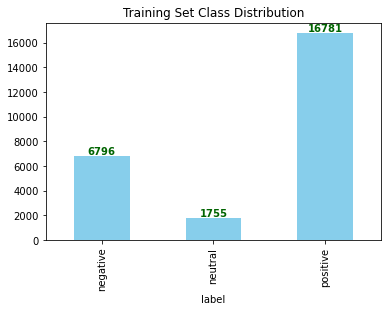

In [13]:
# check class distribution in train set
p1 = pd.DataFrame(y_train).pivot_table(index='label', aggfunc='size').plot(kind='bar', title = 'Training Set Class Distribution',color='Skyblue')
p1.bar_label(p1.containers[0], fontweight='bold',color='darkgreen')

In [14]:
X_train_sw, X_test_sw, y_train_sw, y_test_sw = split(stop_words=True)

[Text(0, 0, '1770'), Text(0, 0, '428'), Text(0, 0, '4135')]

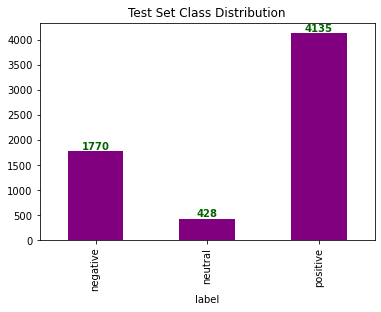

In [15]:
# check class distribution in train set
p1 = pd.DataFrame(y_test).pivot_table(index='label', aggfunc='size').plot(kind='bar', title = 'Test Set Class Distribution',color='Purple')
p1.bar_label(p1.containers[0], fontweight='bold',color='darkgreen')

### Modeling

Define parameter settings to try.

In [55]:
param_grid = {'rf__n_estimators': [100],
              'rf__criterion':["gini"],
              'rf__max_depth': [None],
              'rf__min_samples_leaf': [1],
              'rf__bootstrap':[True]}

Create a function to create an instance of GridSearchCV.

In [56]:
def create_grid_search(ngram_range):
  tfidf = TfidfVectorizer(ngram_range=ngram_range)
  rf = RandomForestClassifier(class_weight="balanced", random_state=42)
  pipe = Pipeline(steps=[("tfidf", tfidf), ("rf", rf)])
  
  search = GridSearchCV(pipe, param_grid, cv=10, scoring="balanced_accuracy", n_jobs=-1)
  return search


Create a function to perform training and evaluation.

In [57]:
def train_evaluate(ngram_range, X_train, X_test, y_train, y_test):
  search = create_grid_search(ngram_range)
  search.fit(X_train, y_train)

  print("Best Parameters:")
  print(search.best_params_)

  y_pred = search.predict(X_test)

  print("Classification Report:")
  print(classification_report(y_test, y_pred))

  print("Confusion Matrix:")
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.show()

  print("AUC Score:")
  print(roc_auc_score(y_test, search.predict_proba(X_test),average='weighted',multi_class='ovr'))

  return search

#### Unigrams

Best Parameters:
{'rf__bootstrap': True, 'rf__criterion': 'gini', 'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.79      0.84      1770
     neutral       1.00      0.00      0.00       428
    positive       0.85      0.98      0.91      4135

    accuracy                           0.86      6333
   macro avg       0.91      0.59      0.58      6333
weighted avg       0.87      0.86      0.83      6333

Confusion Matrix:


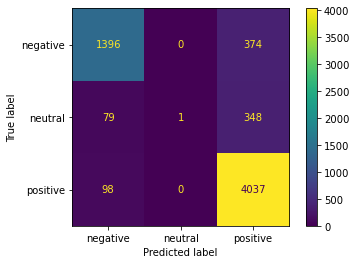

AUC Score:
0.9448442660527829


In [58]:
model_uni = train_evaluate((1, 1), X_train, X_test, y_train, y_test)

#### Unigrams + Stop Words

Best Parameters:
{'rf__bootstrap': True, 'rf__criterion': 'gini', 'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

    negative       0.91      0.64      0.75      1770
     neutral       1.00      0.00      0.00       428
    positive       0.80      0.99      0.88      4135

    accuracy                           0.82      6333
   macro avg       0.90      0.54      0.55      6333
weighted avg       0.85      0.82      0.79      6333

Confusion Matrix:


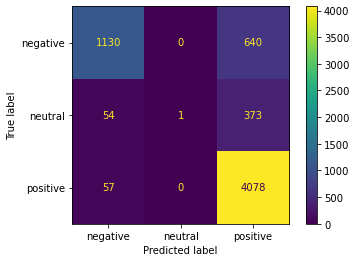

AUC Score:
0.9397833014453613


In [59]:
model_uni_sw = train_evaluate((1, 1), X_train_sw, X_test_sw, y_train_sw, y_test_sw)

#### Bigrams

Best Parameters:
{'rf__bootstrap': True, 'rf__criterion': 'gini', 'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.53      0.65      1770
     neutral       0.67      0.00      0.01       428
    positive       0.77      0.97      0.86      4135

    accuracy                           0.78      6333
   macro avg       0.76      0.50      0.51      6333
weighted avg       0.78      0.78      0.74      6333

Confusion Matrix:


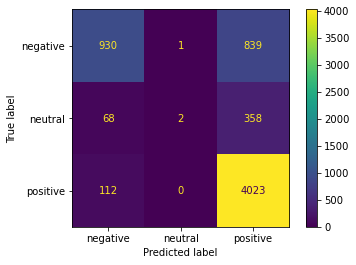

AUC Score:
0.878627976302984


In [60]:
model_bi = train_evaluate((2, 2), X_train, X_test, y_train, y_test)

#### Bigrams + Stop Words

Best Parameters:
{'rf__bootstrap': True, 'rf__criterion': 'gini', 'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

    negative       0.89      0.66      0.76      1770
     neutral       1.00      0.00      0.00       428
    positive       0.81      0.98      0.89      4135

    accuracy                           0.83      6333
   macro avg       0.90      0.55      0.55      6333
weighted avg       0.84      0.83      0.79      6333

Confusion Matrix:


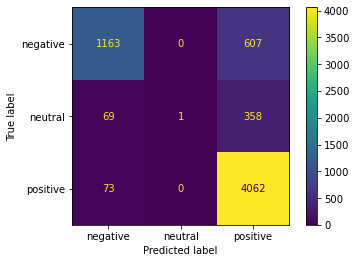

AUC Score:
0.9263467764473718


In [61]:
model_bi_sw = train_evaluate((2, 2), X_train_sw, X_test_sw, y_train_sw, y_test_sw)

#### Unigrams + Bigrams

Best Parameters:
{'rf__bootstrap': True, 'rf__criterion': 'gini', 'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

    negative       0.92      0.68      0.78      1770
     neutral       1.00      0.00      0.00       428
    positive       0.81      0.99      0.89      4135

    accuracy                           0.83      6333
   macro avg       0.91      0.56      0.56      6333
weighted avg       0.85      0.83      0.80      6333

Confusion Matrix:


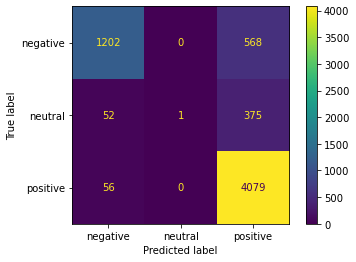

AUC Score:
0.9417337293935558


In [62]:
model_uni_bi = train_evaluate((1, 2), X_train, X_test, y_train, y_test)

#### Unigrams + Bigrams + Stop Words

Best Parameters:
{'rf__bootstrap': True, 'rf__criterion': 'gini', 'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

    negative       0.92      0.62      0.74      1770
     neutral       1.00      0.00      0.00       428
    positive       0.80      0.99      0.88      4135

    accuracy                           0.82      6333
   macro avg       0.90      0.54      0.54      6333
weighted avg       0.84      0.82      0.78      6333

Confusion Matrix:


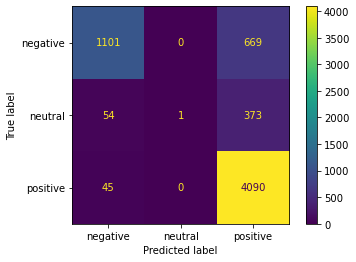

AUC Score:
0.9417315136148036


In [63]:
model_uni_bi_sw = train_evaluate((1, 2), X_train_sw, X_test_sw, y_train_sw, y_test_sw)

### Hyperparameter Tuning

In [36]:
param_grid2 = {'Rf__n_estimators': [5,10,20,100],
              'Rf__criterion':["gini", "entropy"],
              'Rf__max_depth': [None,2,5],
              'Rf__min_samples_leaf': [1,5,10],
              'Rf__bootstrap':[True,False]}

In [37]:
def create_grid_search(ngram_range):
  tfidf = TfidfVectorizer(ngram_range=ngram_range,max_features=10000)
  Rf = RandomForestClassifier(class_weight="balanced", random_state=42)
  pipe = Pipeline(steps=[("tfidf", tfidf), ("Rf", Rf)])
  
  search = GridSearchCV(pipe, param_grid2, cv=10, scoring="balanced_accuracy", n_jobs=-1)
  return search

In [38]:
def train_evaluate(ngram_range, X_train, X_test, y_train, y_test):
  search = create_grid_search(ngram_range)
  search.fit(X_train, y_train)

  print("Best Parameters:")
  print(search.best_params_)

  y_pred = search.predict(X_test)

  print("Classification Report:")
  print(classification_report(y_test, y_pred))

  print("Confusion Matrix:")
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plt.show()
    
  print("AUC Score:")
  print(roc_auc_score(y_test, search.predict_proba(X_test),average='weighted',multi_class='ovr'))

  return search

#### Unigrams

Best Parameters:
{'Rf__bootstrap': False, 'Rf__criterion': 'gini', 'Rf__max_depth': None, 'Rf__min_samples_leaf': 10, 'Rf__n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.83      0.81      1770
     neutral       0.27      0.43      0.33       428
    positive       0.93      0.86      0.90      4135

    accuracy                           0.82      6333
   macro avg       0.67      0.71      0.68      6333
weighted avg       0.85      0.82      0.84      6333

Confusion Matrix:


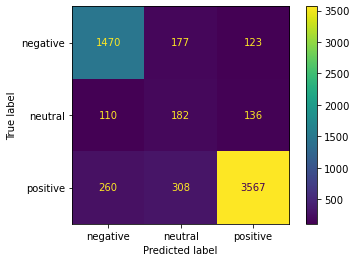

AUC Score:
0.9406060866473285


In [44]:
model_uni2 = train_evaluate((1, 1), X_train, X_test, y_train, y_test)

#### Unigrams + Stop Words

Best Parameters:
{'Rf__bootstrap': False, 'Rf__criterion': 'entropy', 'Rf__max_depth': None, 'Rf__min_samples_leaf': 10, 'Rf__n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

    negative       0.76      0.84      0.80      1770
     neutral       0.32      0.40      0.36       428
    positive       0.93      0.86      0.90      4135

    accuracy                           0.83      6333
   macro avg       0.67      0.70      0.68      6333
weighted avg       0.84      0.83      0.83      6333

Confusion Matrix:


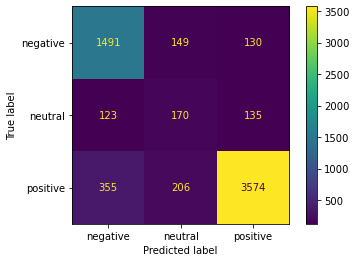

AUC Score:
0.939226601076628


In [39]:
model_uni_sw2 = train_evaluate((1, 1), X_train_sw, X_test_sw, y_train_sw, y_test_sw)

#### Bigrams

Best Parameters:
{'Rf__bootstrap': True, 'Rf__criterion': 'gini', 'Rf__max_depth': None, 'Rf__min_samples_leaf': 5, 'Rf__n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

    negative       0.56      0.79      0.66      1770
     neutral       0.19      0.31      0.23       428
    positive       0.89      0.68      0.77      4135

    accuracy                           0.68      6333
   macro avg       0.55      0.59      0.55      6333
weighted avg       0.75      0.68      0.70      6333

Confusion Matrix:


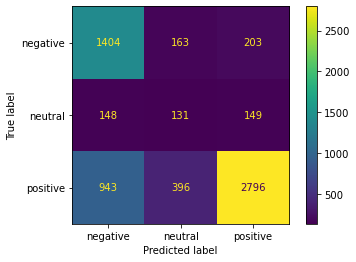

AUC Score:
0.8488624516288327


In [40]:
model_bi2 = train_evaluate((2, 2), X_train, X_test, y_train, y_test)

#### Bigrams + Stop Words

Best Parameters:
{'Rf__bootstrap': False, 'Rf__criterion': 'gini', 'Rf__max_depth': None, 'Rf__min_samples_leaf': 10, 'Rf__n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.79      0.75      1770
     neutral       0.25      0.50      0.33       428
    positive       0.94      0.79      0.86      4135

    accuracy                           0.77      6333
   macro avg       0.63      0.70      0.65      6333
weighted avg       0.83      0.77      0.79      6333

Confusion Matrix:


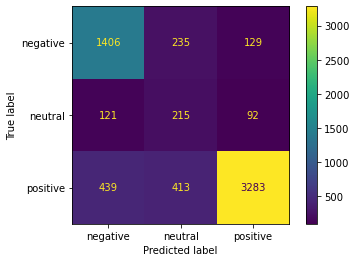

AUC Score:
0.923360900135795


In [41]:
model_bi_sw2 = train_evaluate((2, 2), X_train_sw, X_test_sw, y_train_sw, y_test_sw)

#### Unigrams + Bigrams

Best Parameters:
{'Rf__bootstrap': False, 'Rf__criterion': 'entropy', 'Rf__max_depth': None, 'Rf__min_samples_leaf': 10, 'Rf__n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

    negative       0.81      0.83      0.82      1770
     neutral       0.29      0.46      0.35       428
    positive       0.94      0.86      0.90      4135

    accuracy                           0.83      6333
   macro avg       0.68      0.72      0.69      6333
weighted avg       0.86      0.83      0.84      6333

Confusion Matrix:


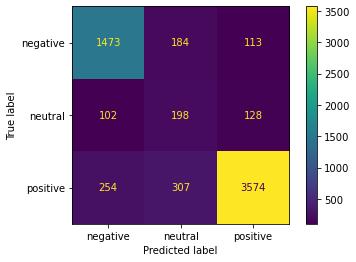

AUC Score:
0.941969962198836


In [42]:
model_uni_bi2 = train_evaluate((1, 2), X_train, X_test, y_train, y_test)

#### Unigrams + Bigrams + Stop Words

Best Parameters:
{'Rf__bootstrap': False, 'Rf__criterion': 'gini', 'Rf__max_depth': None, 'Rf__min_samples_leaf': 10, 'Rf__n_estimators': 100}
Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.85      0.82      1770
     neutral       0.33      0.43      0.37       428
    positive       0.94      0.87      0.90      4135

    accuracy                           0.84      6333
   macro avg       0.68      0.72      0.70      6333
weighted avg       0.85      0.84      0.84      6333

Confusion Matrix:


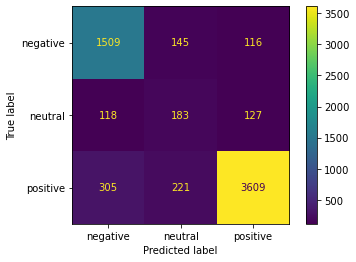

AUC Score:
0.9451467531204406


In [43]:
model_uni_bi_sw2 = train_evaluate((1, 2), X_train_sw, X_test_sw, y_train_sw, y_test_sw)

#### Sanity Check

Positive review?

In [64]:
model_uni_bi_sw2.predict(["The food is great! Especially the unagi!"])

array(['positive'], dtype=object)

Negative review?

In [65]:
model_uni_bi_sw2.predict(["The service sucks! I will never come back again!"])

array(['negative'], dtype=object)

Neutral review?

In [66]:
model_uni_bi_sw2.predict(["The food is decent but the price is a bit high."])

array(['neutral'], dtype=object)

Sarcastic review?

In [67]:
model_uni_bi_sw2.predict(["The food is so good that I think you need next level of taste buds to appreciate it."])

array(['positive'], dtype=object)

Spam review?

In [70]:
model_uni_bi_sw2.predict(["Personal loan with low interest - call 0123456789."])

array(['negative'], dtype=object)

Random text?

In [71]:
model_uni_bi_sw2.predict(["Market is bullish."])

array(['positive'], dtype=object)

Emoji?

In [72]:
model_uni_bi_sw2.predict(["🙂🙂🙂"])

array(['negative'], dtype=object)

In [73]:
model_uni_bi_sw2.predict(["🤬🤬🤬"])

array(['negative'], dtype=object)